# Practical exercise 1

*authors: Asan Agibetov, Geord Dorffner*

Now that you master tensor manipulation and can train simple Neural Networks, you are ready to do some *function approximation* with NNs. As we've seen during the lecture, a neural network is indeed a *universal function approximation machine*. In this exercise you will be asked to compare different neural architectures and their ability to approximate a rather simple sinusoidal real-valued function.

## Historical notes

George Cybenko showed in 1989 that a neural network with sigmoid activation function can approximate continuous functions on $\mathbb{R^n}$[1]. Kurt Hornik in 1991 showed that this approximation property of neural networks is not due to the sigmoid activation function, but rather to the multilayer feedforward architecture of neural networks [2].

[1]: Cybenko, G. (1989) "Approximations by superpositions of sigmoidal functions", Mathematics of Control, Signals, and Systems, 2 (4), 303-314

[2]:  Kurt Hornik (1991) "Approximation Capabilities of Multilayer Feedforward Networks", Neural Networks, 4(2), 251–257.

## Package imports and global settings

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/asan/.Virtualenvs/dl-no-cuda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
# Standard-library imports
import math
import random


# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# from torch.distributions import Normal
# import click
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [16]:
torch.manual_seed(0)

## Data generation and original function

To demonstrate the *universal approximation theorem* in practice, let us fix a continuous function which we would like to approximate

$$
y = cos^2(x) + cos^3(x) + sin^5(x).
$$

We define the function `generate_data` which will generate linearly spaced and uniformly distributed samples of the function $y$. Linearly spaced samples will be used for plotting, while uniformly distributed samples will be fed into the neural network as training samples.

In [17]:
def generate_data(n_samples):
    # Generate 100 random points, the values we want to approximate
    EPS = 1e-5
    x_linear = torch.linspace(-2*math.pi, 2*math.pi, n_samples).view(-1, 1)
    x_sampled = torch.from_numpy(np.random.uniform(-2*math.pi, 2*math.pi, (n_samples,))).view(-1, 1).float()
    
    true_function = lambda x: torch.cos(x)**2 + torch.cos(x)**3 + torch.sin(x)**5
    
    y_sampled = true_function(x_sampled)
    y_linear = true_function(x_linear)
    
    return x_linear, y_linear, x_sampled, y_sampled

This function is continuous and contains many local extrema (this property will be important in your analysis of different neural architectures). Below you can see the plot of this function (sampled at 500 points).

Text(0.5,1,'$y = cos^2(x) + cos^3(x) + sin^5(x)$ with 500 samples')

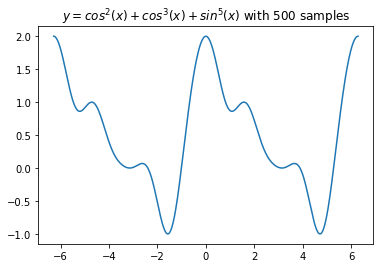

In [18]:
x_plot, y_plot, _, _ = generate_data(500)
plt.plot(x_plot.numpy(), y_plot.numpy())
plt.title("$y = cos^2(x) + cos^3(x) + sin^5(x)$ with 500 samples")

## Neural Network definition

To facilitate the definition of multilayer neural networks with different activation functions, we define `pytorch` class `Approxnet` which inherits all the functionality of the `pytorch` module. You have been exposed to the `pytorch` modules in the previous exercise. Our neural networks, essentially, map real values into real values $\mathbb{R} \mapsto \mathbb{R}$ (because we learn a real-valued function defined on real values) and can have arbitrary number of hidden layers and arbitrary number of hidden neurons per hidden layer.

Throughout this exercise we will be using two activation functions: sigmoid and rectified linear unit (RELU), their definitions are given below, respectively

$$
\begin{align}
sigmoid(x) &= \frac{1}{1 + e^{-x}} \\
relu(x) &= max(0, x).
\end{align}
$$

### Exercise 1.1

**Plot the two activation functions**

In [19]:
class Approxnet(nn.Module):
    def __init__(self,hids_dims, activation="relu"):
        super(Approxnet, self).__init__()

        self.activation = activation
        self.activation_fn = F.relu if activation == "relu" else F.sigmoid

        self.input = nn.Linear(1, hids_dims[0])
        
        self.hids = nn.ModuleList(
                [nn.Linear(h1, h2) for h1, h2 in zip(hids_dims[:-1], hids_dims[1:])])
        self.output = nn.Linear(hids_dims[-1], 1)
        
    def forward(self, x):
        """Output activations of the last hidden neuron layer"""
        output = self.activation_fn(self.input(x))

        for hid in self.hids:
            output = self.activation_fn(hid(output))

        return self.output(output)

In [20]:
def train(model, data, opts):
    """Train a classifier on random points, i.e., a NN that learns to
    reconstruct a function whose values are these random points"""
    x, y = data

    num_epochs = opts["num_epochs"]
    batch_size = opts["batch_size"]
    lr = opts["lr"]
    
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()

    nsamples = len(x)
    # get indices of random samples for the batch generator
    perm = torch.randperm(nsamples).long()

    num_batches = range(1, math.ceil(nsamples / batch_size))
    
    avg_losses = []

    pbar = tqdm(enumerate(range(1, num_epochs + 1)), total=num_epochs)
    for i, epoch in pbar:
        total_loss = 0.0

        for batch in num_batches:
            inputs = x[perm[batch*batch_size:(batch+1) * batch_size]].view(-1, 1).float()
            targets = y[perm[batch*batch_size:(batch+1) * batch_size]].float()

            inputs, targets = Variable(inputs), Variable(targets)
            
            optimizer.zero_grad()

            output = model(inputs)
            loss = F.mse_loss(output, targets, size_average=False)


            total_loss += loss.data[0]
            
            # compute gradients
            # backpropagate: update weights
            loss.backward()        
            optimizer.step()
            
        # log partial results
        avg_loss = total_loss/batch
        avg_losses.append(avg_loss)
        pbar.set_description("epoch: {0}, avg loss: {1:.2f}".format(epoch, avg_loss))
        
    return avg_losses

## Function approximation summary and visualization

Finally, we have all the ingredients to do the function approximation. We further define a couple of functions for the summary of the training of sigmoid and relu neural networks, and for the plotting of the results of the approximation and average loss errors.

In [21]:
def train_models(hid_dims, num_samples, num_epochs, batch_size, lr):
    # Training settings
    opts = {
        "hid_dims": hid_dims,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "lr": lr,
    }
    
    print("training models with params")
    for key, value in opts.items():
        print("{}: {}".format(key, value))

    # Model, i.e., Neural Network
    sigmoid_model = Approxnet(hid_dims, activation="sigmoid")
    relu_model = Approxnet(hid_dims, activation="relu")
    print(sigmoid_model)
    print(relu_model)

    print("generating {} samples".format(num_samples))
    x_linear, y_linear, x_sampled, y_sampled = generate_data(num_samples)

    print("training sigmoid model")
    sigmoid_avg_losses = train(sigmoid_model, (x_sampled, y_sampled), opts)
        
    print("training relu model")
    relu_avg_losses = train(relu_model, (x_sampled, y_sampled), opts)

    return {
        "sigmoid": {
            "model": sigmoid_model,
            "losses": sigmoid_avg_losses,
        },
        "relu": {
            "model": relu_model,
            "losses": relu_avg_losses,
        },
        "x_linear": x_linear,
        "y_linear": y_linear,
        "x_sampled": x_sampled,
        "y_sampled": y_sampled,
    }    

In [22]:
def plot_approximations(output_object):
    
    output_object["sigmoid"]["model"].eval()
    output_object["relu"]["model"].eval()

    inputs = Variable(output_object["x_sampled"])
    sigmoid_output = output_object["sigmoid"]["model"](inputs)
    relu_output = output_object["relu"]["model"](inputs)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.plot(output_object["x_linear"].squeeze().numpy(), output_object["y_linear"].squeeze().numpy(), 'g', label="true function")
    plt.scatter(output_object["x_sampled"].squeeze().numpy(), sigmoid_output.data.squeeze().numpy(), alpha=0.5, c='r', s=5, label="sigmoid approximation")
    plt.legend()
    
    plt.subplot(212)
    plt.plot(output_object["x_linear"].squeeze().numpy(), output_object["y_linear"].squeeze().numpy(), 'g', label="true function")
    plt.scatter(output_object["x_sampled"].squeeze().numpy(), relu_output.data.squeeze().numpy(), alpha=0.5, c='b', s=5, label="relu approximation")
    plt.legend()
    
    print("MSE for sigmoid {}".format(torch.norm(sigmoid_output.data - output_object["y_sampled"])))
    print("MSE for RELU {}".format(torch.norm(relu_output.data - output_object["y_sampled"])))
    
    plt.show()

In [23]:
def plot_losses(output_object):
    sigmoid_losses = output_object["sigmoid"]["losses"]
    relu_losses = output_object["relu"]["losses"]
    plt.plot(sigmoid_losses, "r-", label="sigmoid average losses")
    plt.plot(relu_losses, "b-", label="relu average losses")
    plt.xlabel("epochs")
    plt.ylabel("avg. loss")

    plt.legend()
    plt.show()

## Function approximation experiments

Below we provide the initial experiment, which you should take as an example when you perform the exercises announced further in the notebooks. In particular, we fix the hyperparamaters of the training process to `3` hidden layers each with `200` neurons, `500` training samples of the continuous function. We will be optimizing our network for `500` epochs (iterations), and the learning rate will be set to `0.001`. Also, within each epoch we will be updating parameters for random batches of `50` training samples.

In [24]:
hid_dims = [200, 200, 200]
num_samples = 500
num_epochs = 500
batch_size = 50
lr = 1e-3

output_obj = train_models(hid_dims, num_samples, num_epochs, batch_size, lr)

epoch: 9, avg loss: 31.88:   1%|          | 4/500 [00:00<00:23, 20.86it/s]

training models with params
hid_dims: [200, 200, 200]
lr: 0.001
batch_size: 50
num_epochs: 500
Approxnet(
  (input): Linear(in_features=1, out_features=200)
  (hids): ModuleList(
    (0): Linear(in_features=200, out_features=200)
    (1): Linear(in_features=200, out_features=200)
  )
  (output): Linear(in_features=200, out_features=1)
)
Approxnet(
  (input): Linear(in_features=1, out_features=200)
  (hids): ModuleList(
    (0): Linear(in_features=200, out_features=200)
    (1): Linear(in_features=200, out_features=200)
  )
  (output): Linear(in_features=200, out_features=1)
)
generating 500 samples
training sigmoid model


epoch: 12, avg loss: 8.02:   1%|          | 6/500 [00:00<00:14, 33.10it/s]

training relu model


epoch: 500, avg loss: 0.11: 100%|██████████| 500/500 [00:11<00:00, 44.09it/s]


When we visualize the learnt approximations, we can see that both architectures get quiet close to the true function. The notable distinction being that the relus tend to approximate the function better at the local extrema points, while the sigmoid approximation tends to *smooth out* rapid local variations. The sigmoid approximation can learn to represent these extrema points better, but on average it will need more "samples" around those points than the relu activation function. This is due to the fact that the *sigmoid* activation functions produce a weighted sum of smooth functions, while the *relu* activation produces a weighted sum of piecewise linear functions.

MSE for sigmoid 3.374689562910463
MSE for RELU 1.6113999179519862


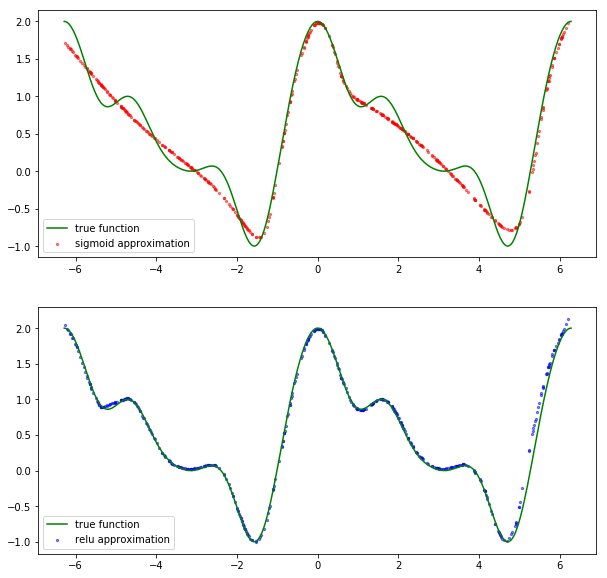

In [25]:
plot_approximations(output_obj)

Theoretically, the two multi-layer neural networks with two different activation functions have an equivalent representation capacity, however, in practice *relu* activation function gives faster convergence rates and generally requires fewer number of samples to achieve a reasonably good approximation. For instance, below you can see the plot of decreasing *mean squared errors* between the approximation and the true function, while both architectures converge towards a $0$ mean squared error, the neural network with *relu* activation function does so on average faster.

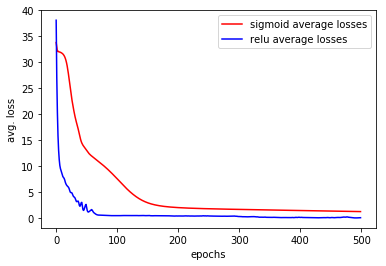

In [26]:
plot_losses(output_obj)

### Exercise 1.2

For both activation functions, fix all hyperparameters as given, and increase gradually the number of samples. Observe and report when the MSE of both activations functions become equal (within small epsilon). For instance try training the networks with `1000, 1500, 2000, 5000` samples. When does the sigmoid activation function start approximating all local extrema of the function? In your analysis also include the number of seconds it take to train both networks.

### Exercise 1.3

Reduce the number of hidden layers to `1` with `20` neurons, i.e. `hid_dims = [20]`, retrain and report the *shape* of the approximations for varying number of samples (e.g., `500, 1000, 2000`). Recall that the sigmoid activation NN will be equivalent to the weighted sum of *smooth* functions, while the *relu* activation will be equivalent to the weighted sum of piecewise linear functions. Report MSE, plots of approximations and loss errors, as well as the time it takes to train, as in the previous exercise.